In [1]:
import torch
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
_ = torch.manual_seed(1000)

/Users/aayush/venvs/EE5606_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generate dataset

In [2]:
def generate_dataset(num_samples = 5000, min_input_size = 2, max_input_size = 12):

    """
    Returns (X, y)
    X: a torch tensor of size num_samples X input_size X 2
    X[i] is a tensor of size input_size X 2 where input_size is a random number between min_input_size and max_input_size
    X[i][j] is a random vector of size 2
    X[i][j][0] is a random number between 0 and 1
    X[i][j][1] is a random number is either 0 or 1 and there can be exactly two 1s

    y: a torch tensor of size num_samples X 1
    y[i] is the sum of all the numbers in X[i][j][0] (for all j) where X[i][j][1] is 1
    """

    if min_input_size > max_input_size:
        print("min_input_size should be less than max_input_size, setting them to be equal")
        min_input_size = max_input_size

    if min_input_size < 2:
        print("min_input_size should be at least 2, setting it to 2")
        min_input_size = 2

    X = torch.zeros(num_samples, max_input_size, 2)
    for i in range(num_samples):
        input_size = random.randint(min_input_size, max_input_size)
        X[i, :input_size, 0] = torch.rand(input_size)
        X[i, :input_size, 1] = torch.zeros(input_size)
        two_random_indices = random.sample(range(input_size), 2)
        X[i, two_random_indices, 1] = 1

    return X, torch.sum(X[:, :, 0] * X[:, :, 1], dim = 1)

X, y = generate_dataset()
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 420)

torch.Size([5000, 12, 2])
torch.Size([5000])


In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
# print(X_train[0:4])
# print(y_train[0:4])

torch.Size([4000, 12, 2])
torch.Size([4000])
torch.Size([1000, 12, 2])
torch.Size([1000])


### Helper Functions

In [4]:
def loss_fn(output, target):
  return torch.sum(torch.square(output - target))

### Elmon RNN Model

In [5]:
class ElmonRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ElmonRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.wxh = torch.nn.Linear(input_size, hidden_size, bias=True)
        self.whh = torch.nn.Linear(hidden_size, hidden_size, bias=True)
        self.why = torch.nn.Linear(hidden_size, output_size, bias=True)
        
    def forward(self, input, hidden):
        '''
        input: tensor of shape (self.input_size, )
        hidden: tensor of shape (self.hidden_size, )
        
        output: tensor of shape (self.output_size, )
        '''
        hidden = torch.tanh(self.whh(hidden) + self.wxh(input))
        assert hidden.shape == (self.hidden_size, ) 

        output = self.why(hidden)
        assert output.shape == (self.output_size, )

        return output, hidden

#### Setting up hyperparaters & running the ElmonRNN model

In [6]:
n_hidden = 10
model = ElmonRNN(input_size = 2, hidden_size = n_hidden, output_size = 1)
n_epochs = 10
learning_rate = 0.001

training_losses = []
testing_losses = []

# criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(n_epochs):
    indices = torch.randperm(X_train.shape[0])
    X_train, y_train = X_train[indices], y_train[indices]
    
    train_epoch_loss = 0

    model.train()
    for index, input in enumerate(X_train):
        
        hidden = torch.zeros(size=(model.hidden_size, ), dtype=torch.float)
        for xt in input:
            assert xt.shape == (2, )
            output, hidden = model(xt, hidden)
            assert output.shape == (1, )
            assert hidden.shape == (model.hidden_size, )
        
        # loss = criterion(output, y[index].unsqueeze(0))
        loss = loss_fn(output, y_train[index].unsqueeze(0))
        train_epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_epoch_loss = 0

    model.eval()
    with torch.no_grad():
        for index, x in enumerate(X_test):
            hidden = torch.zeros(size=(model.hidden_size, ), dtype=torch.float)
            for xt in x: 
                assert xt.shape == (2, )
                output, hidden = model(xt, hidden)
                assert output.shape == (1, )
                assert hidden.shape == (model.hidden_size, )

            # loss = criterion(output, y_test[index].unsqueeze(0))
            loss = loss_fn(output, y_test[index].unsqueeze(0))
            test_epoch_loss += loss.item()

    training_losses.append(train_epoch_loss / X_train.shape[0])
    testing_losses.append(test_epoch_loss / X_test.shape[0])

    print(f"Epoch: {epoch + 1}/{n_epochs} :: Average Training Loss: {train_epoch_loss / X_train.shape[0]}, Average Testing Loss: {test_epoch_loss / X_test.shape[0]}")

elmon_loss = testing_losses[-1]

Epoch: 1/10 :: Average Training Loss: 0.1871954718057877, Average Testing Loss: 0.17365228270314237
Epoch: 2/10 :: Average Training Loss: 0.17057684474046725, Average Testing Loss: 0.17406426243776837
Epoch: 3/10 :: Average Training Loss: 0.16908103774076647, Average Testing Loss: 0.17436943101852653
Epoch: 4/10 :: Average Training Loss: 0.16875064065169681, Average Testing Loss: 0.17399123324398372
Epoch: 5/10 :: Average Training Loss: 0.155155932289867, Average Testing Loss: 0.15464915238518978
Epoch: 6/10 :: Average Training Loss: 0.05578418635316459, Average Testing Loss: 0.020814991429901824
Epoch: 7/10 :: Average Training Loss: 0.01933420873178768, Average Testing Loss: 0.03413307036117202
Epoch: 8/10 :: Average Training Loss: 0.014233391207814645, Average Testing Loss: 0.010537621902837739
Epoch: 9/10 :: Average Training Loss: 0.01178669723810474, Average Testing Loss: 0.008077244054892475
Epoch: 10/10 :: Average Training Loss: 0.0104077450155707, Average Testing Loss: 0.0076020

#### Plotting loss vs epochs

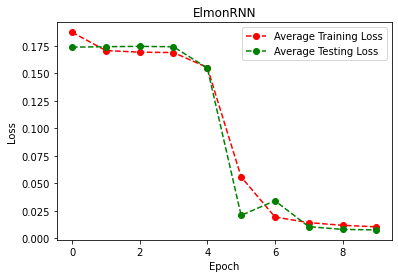

In [7]:
plt.plot(training_losses, label = "Average Training Loss", color = "red", linestyle = "dashed", marker = "o")
plt.plot(testing_losses, label = "Average Testing Loss", color = "green", linestyle = "dashed", marker = "o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ElmonRNN")
plt.legend()
plt.show()

### LSTM Model

In [8]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.wi = torch.nn.Linear(input_size + hidden_size, hidden_size, bias=True)
        self.wf = torch.nn.Linear(input_size + hidden_size, hidden_size, bias=True)
        self.wo = torch.nn.Linear(input_size + hidden_size, hidden_size, bias=True)
        self.wg = torch.nn.Linear(input_size + hidden_size, hidden_size, bias=True)
        self.why = torch.nn.Linear(hidden_size, output_size, bias=True)

    def forward(self, input, hidden, cell):
        '''
        input: tensor of shape (self.input_size, )
        hidden: tensor of shape (self.hidden_size, )
        cell: tensor of shape (self.hidden_size, )
        
        output: tensor of shape (self.output_size, )
        '''
        i = torch.sigmoid(self.wi(torch.cat((input, hidden), dim=0)))
        assert i.shape == (self.hidden_size, )

        f = torch.sigmoid(self.wf(torch.cat((input, hidden), dim=0)))
        assert f.shape == (self.hidden_size, )

        o = torch.sigmoid(self.wo(torch.cat((input, hidden), dim=0)))
        assert o.shape == (self.hidden_size, )

        g = torch.tanh(self.wg(torch.cat((input, hidden), dim=0)))
        assert g.shape == (self.hidden_size, )

        cell = f * cell + i * g
        assert cell.shape == (self.hidden_size, )

        hidden = o * torch.tanh(cell)
        assert hidden.shape == (self.hidden_size, )

        output = self.why(hidden)

        return output, hidden, cell

#### Setting up hyperparaters & running the ElmonRNN model

In [9]:
n_hidden = 10
model = LSTM(input_size = 2, hidden_size = n_hidden, output_size = 1)
n_epochs = 6
learning_rate = 0.01

training_losses = []
testing_losses = []

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(n_epochs):
    indices = torch.randperm(X_train.shape[0])
    X_train, y_train = X_train[indices], y_train[indices]
    
    train_epoch_loss = 0

    model.train()
    for index, input in enumerate(X_train):
        
        hidden = torch.zeros(size=(model.hidden_size, ), dtype=torch.float, requires_grad=True)
        cell = torch.zeros(size=(model.hidden_size, ), dtype=torch.float, requires_grad=True)
        for xt in input:
            assert xt.shape == (2, )
            output, hidden, cell = model(xt, hidden, cell)
            assert output.shape == (1, )
            assert hidden.shape == (model.hidden_size, )
            assert cell.shape == (model.hidden_size, )

        smtg = y_train[index].unsqueeze(0)
        loss = criterion(output, smtg)
        # loss = loss_fn(output, smtg)
        train_epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_epoch_loss = 0

    model.eval()
    with torch.no_grad():
        for index, input in enumerate(X_test):
            
            hidden = torch.zeros(size=(model.hidden_size, ))
            cell = torch.zeros(size=(model.hidden_size, ))
            for xt in input:
                assert xt.shape == (2, )
                output, hidden, cell = model(xt, hidden, cell)
                assert output.shape == (1, )
                assert hidden.shape == (model.hidden_size, )
                assert cell.shape == (model.hidden_size, )

            smtg = y_test[index].unsqueeze(0)
            loss = criterion(output, smtg)
            # loss = loss_fn(output, smtg)
            test_epoch_loss += loss.item()

    training_losses.append(train_epoch_loss / X_train.shape[0])
    testing_losses.append(test_epoch_loss / X_test.shape[0])

    print(f"Epoch: {epoch + 1}/{n_epochs} :: Average Training Loss: {train_epoch_loss / X_train.shape[0]}, Average Testing Loss: {test_epoch_loss / X_test.shape[0]}")

lstm_loss = testing_losses[-1]

Epoch: 1/6 :: Average Training Loss: 0.09219946742259688, Average Testing Loss: 0.0018834880248203092
Epoch: 2/6 :: Average Training Loss: 0.002338278483790105, Average Testing Loss: 0.0015900055129341411
Epoch: 3/6 :: Average Training Loss: 0.00161054871826539, Average Testing Loss: 0.0017285166481272717
Epoch: 4/6 :: Average Training Loss: 0.0010840472934429668, Average Testing Loss: 0.0010197420474630334
Epoch: 5/6 :: Average Training Loss: 0.0009352891150393941, Average Testing Loss: 0.0005446413334094302
Epoch: 6/6 :: Average Training Loss: 0.0006419182944806976, Average Testing Loss: 0.00026240501288099337


#### Plotting loss vs epochs

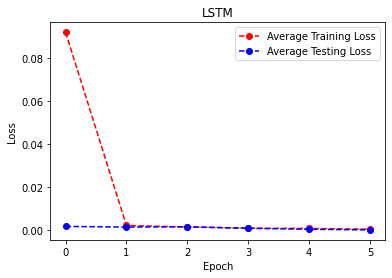

In [10]:
plt.plot(training_losses, label = "Average Training Loss", color = "red", linestyle = "dashed", marker = "o")
plt.plot(testing_losses, label = "Average Testing Loss", color = "blue", linestyle = "dashed", marker = "o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM")
plt.legend()
plt.show()

### GRU Model

In [11]:
class GRU(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.wz = torch.nn.Linear(input_size + hidden_size, hidden_size, bias=True)
        self.wr = torch.nn.Linear(input_size + hidden_size, hidden_size, bias=True)
        self.wh = torch.nn.Linear(input_size + hidden_size, hidden_size, bias=True)
        self.why = torch.nn.Linear(hidden_size, output_size, bias=True)

    def forward(self, input, hidden):
        '''
        input: tensor of shape (self.input_size, )
        hidden: tensor of shape (self.hidden_size, )
        
        output: tensor of shape (self.output_size, )
        '''
        z = torch.sigmoid(self.wz(torch.cat((input, hidden), dim=0)))
        assert z.shape == (self.hidden_size, )

        r = torch.sigmoid(self.wr(torch.cat((input, hidden), dim=0)))
        assert r.shape == (self.hidden_size, )

        h = torch.tanh(self.wh(torch.cat((input, r * hidden), dim=0)))
        assert h.shape == (self.hidden_size, )

        hidden = (1 - z) * hidden + z * h
        assert hidden.shape == (self.hidden_size, )

        output = self.why(hidden)

        return output, hidden

#### Setting up hyperparaters & running the ElmonRNN model

In [12]:
n_hidden = 10
model = GRU(input_size = 2, hidden_size = n_hidden, output_size = 1)
n_epochs = 3
learning_rate = 0.01

training_losses = []
testing_losses = []

# criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(n_epochs):
    indices = torch.randperm(X_train.shape[0])
    X_train, y_train = X_train[indices], y_train[indices]
    
    train_epoch_loss = 0

    model.train()
    for index, input in enumerate(X_train):
        
        hidden = torch.zeros(size=(model.hidden_size, ), dtype=torch.float, requires_grad=True)
        for xt in input:
            assert xt.shape == (2, )
            output, hidden = model(xt, hidden)
            assert output.shape == (1, )
            assert hidden.shape == (model.hidden_size, )

        # loss = criterion(output, y[index].unsqueeze(0))
        loss = loss_fn(output, y_train[index].unsqueeze(0))
        train_epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_epoch_loss = 0

    model.eval()
    with torch.no_grad():
        for index, input in enumerate(X_test):
            
            hidden = torch.zeros(size=(model.hidden_size, ))
            for xt in input:
                assert xt.shape == (2, )
                output, hidden = model(xt, hidden)
                assert output.shape == (1, )
                assert hidden.shape == (model.hidden_size, )

            # loss = criterion(output, y_test[index].unsqueeze(0))
            loss = loss_fn(output, y_test[index].unsqueeze(0))
            test_epoch_loss += loss.item()

    training_losses.append(train_epoch_loss / X_train.shape[0])
    testing_losses.append(test_epoch_loss / X_test.shape[0])

    print(f"Epoch: {epoch + 1}/{n_epochs} :: Average Training Loss: {train_epoch_loss / X_train.shape[0]}, Average Testing Loss: {test_epoch_loss / X_test.shape[0]}")

gru_loss = testing_losses[-1]

Epoch: 1/3 :: Average Training Loss: 0.023570242242706645, Average Testing Loss: 0.0008189724347324088
Epoch: 2/3 :: Average Training Loss: 0.0014824011228923714, Average Testing Loss: 0.00034865550802187073
Epoch: 3/3 :: Average Training Loss: 0.0006928051354531128, Average Testing Loss: 0.00022059740697747898


#### Plotting loss vs epochs

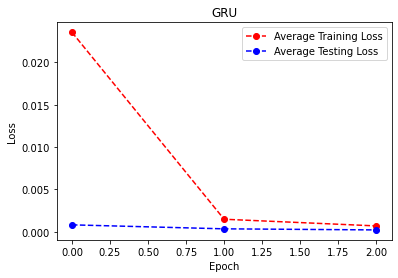

In [13]:
plt.plot(training_losses, label = "Average Training Loss", color = "red", linestyle = "dashed", marker = "o")
plt.plot(testing_losses, label = "Average Testing Loss", color = "blue", linestyle = "dashed", marker = "o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GRU")
plt.legend()
plt.show()

### Baseline Model

In [14]:
baseline_loss = 0
for index, input in enumerate(X_test):
    baseline_loss += loss_fn(torch.tensor([1.0]), y_test[index].unsqueeze(0)).item()
baseline_loss /= X_test.shape[0]

In [15]:
print(elmon_loss)

0.007602035497132433


### Plotting losses on test data for different models

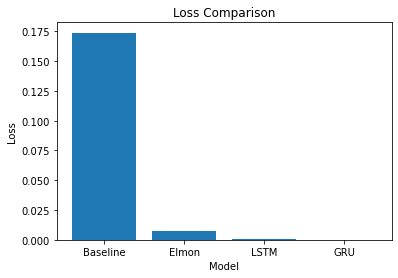

In [16]:
plt.bar(["Baseline", "Elmon", "LSTM", "GRU"], [baseline_loss, elmon_loss, lstm_loss, gru_loss])
plt.title("Loss Comparison")
plt.xlabel("Model")
plt.ylabel("Loss")
plt.show()

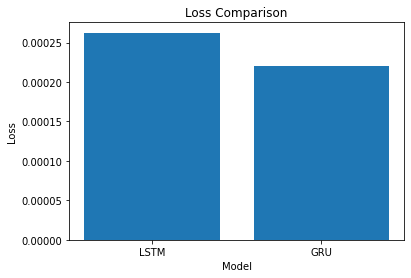

In [17]:
plt.bar(["LSTM", "GRU"], [lstm_loss, gru_loss])
plt.title("Loss Comparison")
plt.xlabel("Model")
plt.ylabel("Loss")
plt.show()